## Summary

### Visualised:
- __Box plots for the continuous variables.__
    - Unsurprisingly there were a large number of outliers for the non-stroke class due to the imbalance.
    - `age_corr` was clearly a standout in terms of separating the 2 classes, despite the imbalance.
- __Histogram for continuous variables__
    - Whilst `average_blood_sugar` looks skewed, it should not be too much of a problem. 
    - `BMI` looks much nicer, closer to a normal distribution.
    - However, the distribution of the continuous variables with respect to the label does not appear to help differentiate them. 
- __Count plots were used for the binary variables, and due to the class imbalance it was hard to see anything significant.__

### Feature Engineering:
- __one-hot encoding__
    - We OneHot encode all the binary variables
- __binning__
    - Age: 0-18 child, 18-45 adult, 45-70 senior, 70+ elderly
    - Sugar: 0-100 low, 100-150 medium, 150-250 high, 250+ very high
    - BMI: < 18.5 low (unhealthy), 18-25 medium (normal), 25-30 high (at risk), 30+ very high (at high risk)
- __combining classes__
    - we create a new feature that indicates whether a person has ever smoked before (essentially an `or` on `quit` and `active_smoker`
- __normalisation of data__
    - all continuous data is normalised to between 0 and 1
    - Note: This is done in the next notebook
    
### SMOTE Upsampling

We use SMOTE-NC which deals with categorical and nominal variables (hence NC) to upsample the dataset to contain 20% of the minority class. The end class ratio is 22804:4540 ~ 16%

### Updated Dataset 
The processed dataset was saved to `train_processed.csv`.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
stk = pd.read_csv("../data/train_processed2.csv")

In [3]:
stk["high_BP"] = stk["high_BP"].apply(lambda x: str(int(x)))
stk["heart_condition_detected_2017"] = stk["heart_condition_detected_2017"].apply(lambda x: str(int(x)))
stk["married"] = stk["married"].apply(lambda x: str(int(x)))
stk["stroke_in_2018"] = stk["stroke_in_2018"].apply(lambda x: str(int(x)))

In [4]:
stk.describe()

,id,average_blood_sugar,BMI,age_corr
count,33531.000000,33531.000000,33531.000000,33531.000000
mean,21727.405267,108.295900,30.933333,44.879365
std,12497.495702,42.321943,7.779938,22.532108
min,2.000000,59.600000,12.600000,3.000000
25%,10905.500000,81.920000,25.600000,27.000000
50%,21717.000000,95.920000,30.100000,46.000000
75%,32578.500000,116.260000,35.200000,63.000000
max,43399.000000,295.650000,99.900000,85.000000


In [5]:
stk.dtypes

id                                 int64
high_BP                           object
heart_condition_detected_2017     object
married                           object
smoker_status                     object
average_blood_sugar              float64
BMI                              float64
job_status_corr                   object
living_area_corr                  object
sex_corr                          object
age_corr                           int64
stroke_in_2018                    object
dtype: object

In [6]:
stk.drop(labels="id", axis=1, inplace=True)

In [7]:
stk.smoker_status.isnull().value_counts()

False    33531
Name: smoker_status, dtype: int64

In [8]:
stk["stroke_in_2018"].value_counts()
print(round(453/(22804+453), 4))
print(round(22804/(22804+453), 4))

0.0195
0.9805


Now, the baseline prediction is an insane 98% so a more appropriate metric to use would be AUC-ROC. 

### Visualise Data 

We first look at how the data is separated based on the label.

Admittedly in hindsight this will likely not yield much insight for counts because the classes are so imbalanced

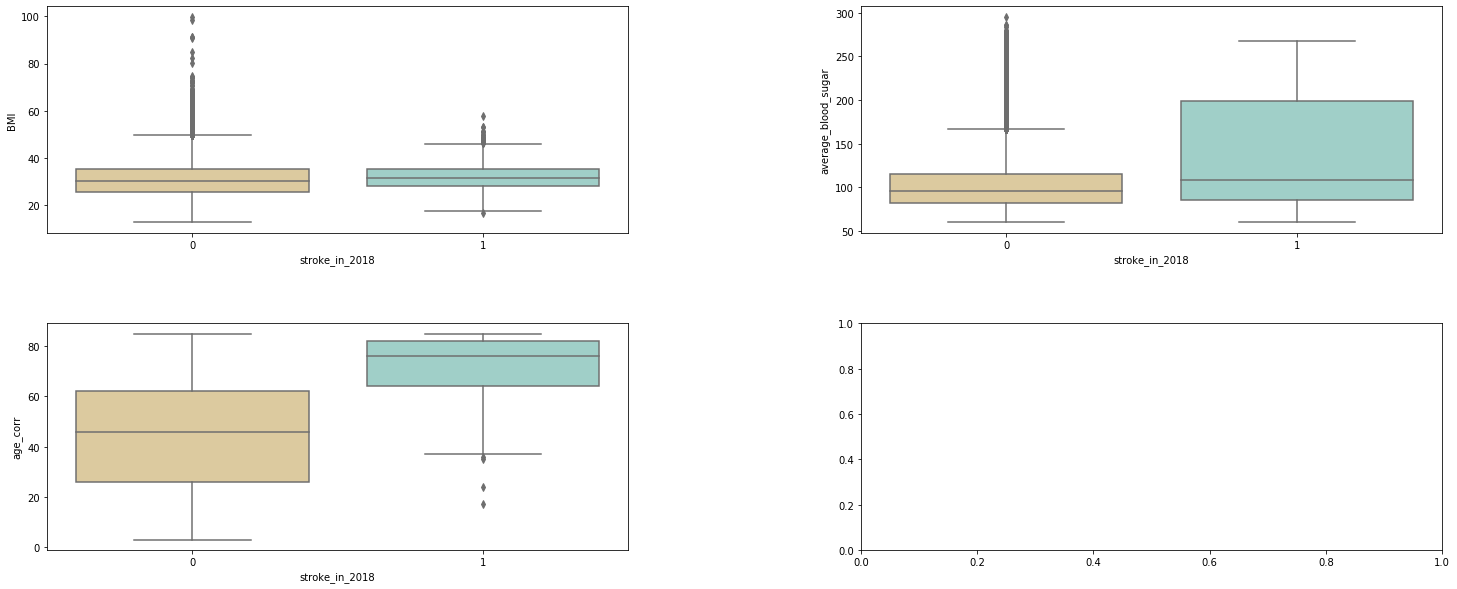

In [9]:
fig, axes = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(25)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

label = "stroke_in_2018"
cols_continuous = ["BMI", "average_blood_sugar"]

sns.boxplot(x = label, y = "BMI", palette = "BrBG", 
            data = stk, ax=axes[0, 0])
sns.boxplot(x = label, y = "average_blood_sugar", palette = "BrBG", 
            data = stk, ax=axes[0, 1])
sns.boxplot(x = label, y = "age_corr", palette = "BrBG", 
            data = stk, ax=axes[1, 0])

<div class="alert alert-block alert-success">
Age is clearly the most promising feature of the dataset.
</div>

 Perhaps we may be able to get some more out of this feature with some feature engineering.

In [10]:
stk.dtypes

high_BP                           object
heart_condition_detected_2017     object
married                           object
smoker_status                     object
average_blood_sugar              float64
BMI                              float64
job_status_corr                   object
living_area_corr                  object
sex_corr                          object
age_corr                           int64
stroke_in_2018                    object
dtype: object

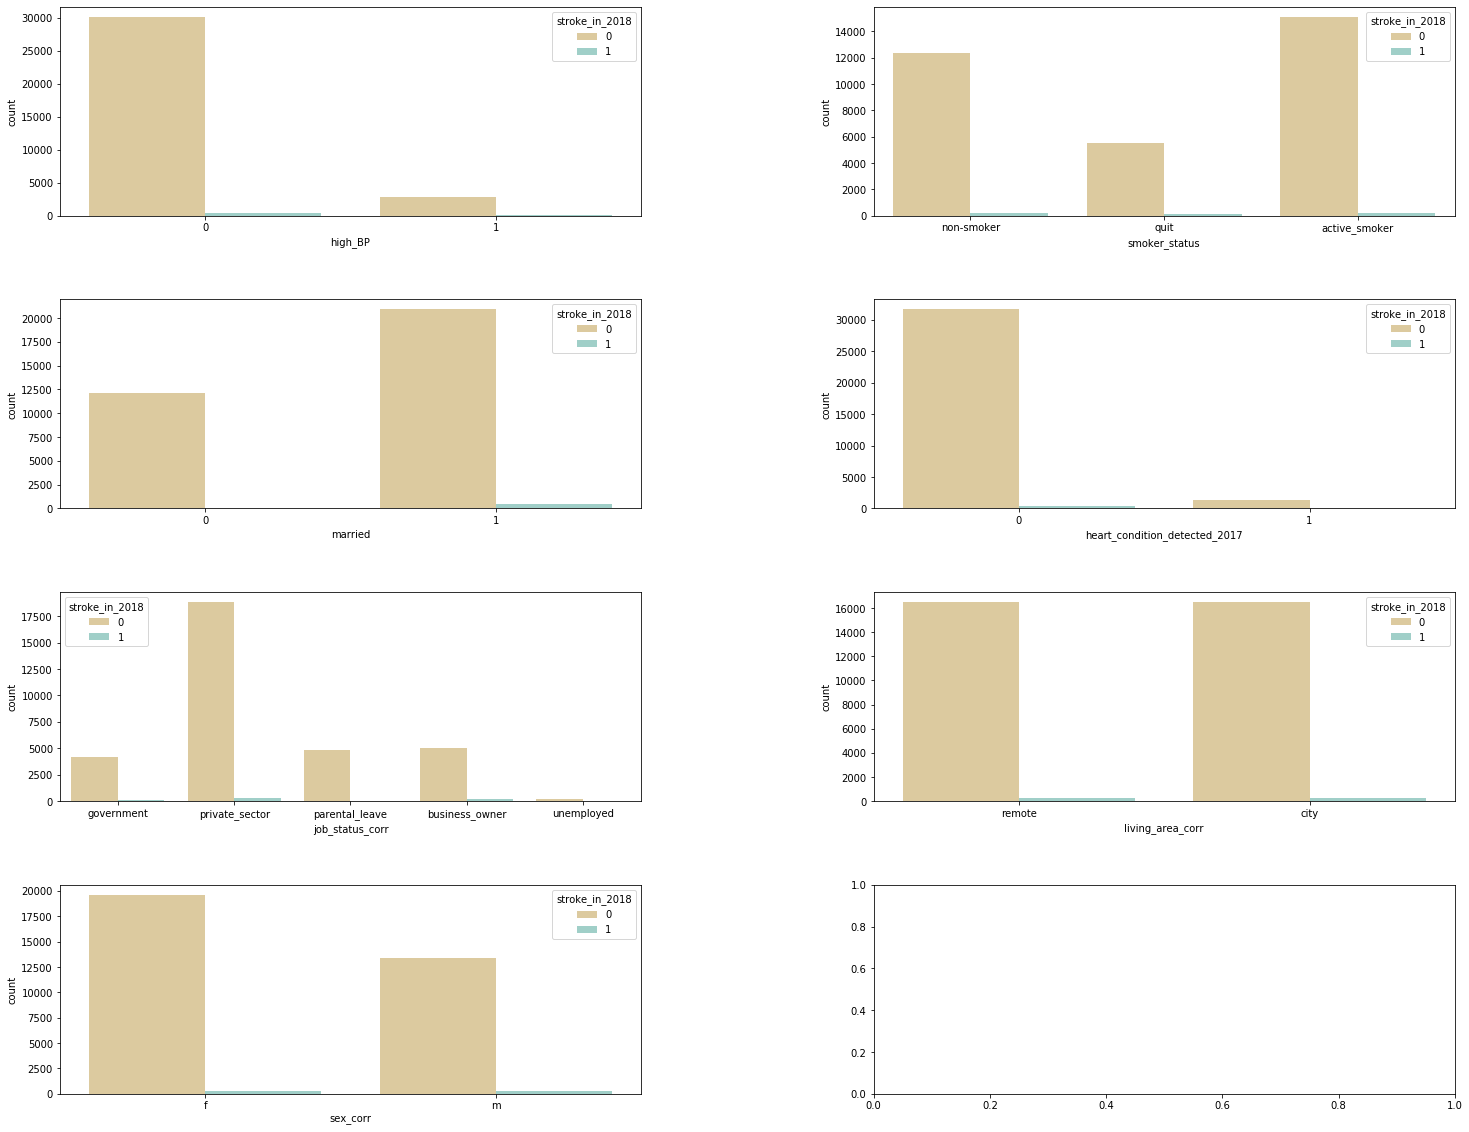

In [11]:
fig, axes = plt.subplots(4, 2)
fig.set_figheight(20)
fig.set_figwidth(25)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

label = "stroke_in_2018"
cols_categorical = ["high_BP", "smoker_status", "married", "heart_condition_detected_2017",
                   "job_status_corr", "living_area_corr"]

sns.countplot(x = "high_BP", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[0, 0])
sns.countplot(x = "smoker_status", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[0, 1])
sns.countplot(x = "married", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[1, 0])
sns.countplot(x = "heart_condition_detected_2017", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[1, 1])
sns.countplot(x = "job_status_corr", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[2, 0])
sns.countplot(x = "living_area_corr", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[2, 1])
sns.countplot(x = "sex_corr", hue = "stroke_in_2018", 
              data = stk, palette = "BrBG", ax=axes[3, 0])


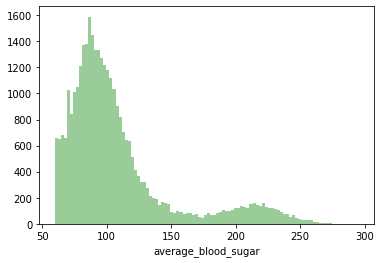

In [12]:
sns.distplot(stk["average_blood_sugar"], 
             kde = False, bins = 100, color = "green")

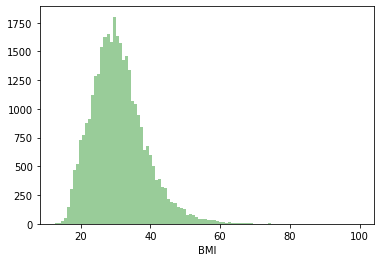

In [13]:
sns.distplot(stk["BMI"], kde = False, bins = 100, color = "green")

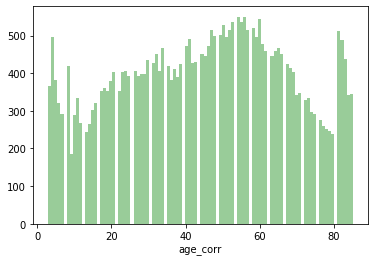

In [14]:
sns.distplot(stk["age_corr"], 
             kde = False, bins = 100, color = "green")

### Feature Engineering

We're going to do a couple of things

1) One-hot encoding
    - as necessary with the binary variables
2) Binning 
    - Going to try binning
        - age (by 10)
        - sugar (by 50?)
        - BMI (by the typical groups)
        
3) Combining Classes
    - Smoking: If you ever smoked at all, you are put into one group
        
4) Normalising
    - Normalise the continuous variables
        
We will add more when we come across it
        
According to [here](https://www.betterhealth.vic.gov.au/health/healthyliving/body-mass-index-bmi) if you have a BMI of:
- Under 18.5 – you are considered underweight and possibly malnourished.
- 18.5 to 24.9 – you are within a healthy weight range for young and middle-aged adults.
- 25.0 to 29.9 – you are considered overweight.
- Over 30 – you are considered obese.

<div class="alert alert-block alert-info">
OneHot Encoding
</div>

Using `pd.get_dummies()`, we can easily handle categorical variables.

In [15]:
stk_onehot = stk.join(pd.get_dummies(stk[cols_categorical]))
stk_onehot.head()

,high_BP,heart_condition_detected_2017,married,smoker_status,average_blood_sugar,BMI,job_status_corr,living_area_corr,sex_corr,age_corr,...,married_1,heart_condition_detected_2017_0,heart_condition_detected_2017_1,job_status_corr_business_owner,job_status_corr_government,job_status_corr_parental_leave,job_status_corr_private_sector,job_status_corr_unemployed,living_area_corr_city,living_area_corr_remote
0,1,0,1,non-smoker,71.67,36.6,government,remote,f,61,...,1,1,0,0,1,0,0,0,0,1
1,0,0,0,quit,107.95,30.4,private_sector,remote,f,30,...,0,1,0,0,0,0,1,0,0,1
2,1,0,1,active_smoker,76.49,42.1,government,remote,f,51,...,1,1,0,0,1,0,0,0,0,1
3,0,0,1,quit,113.98,57.3,government,city,f,54,...,1,1,0,0,1,0,0,0,1,0
4,0,0,0,active_smoker,70.60,26.7,private_sector,city,m,27,...,0,1,0,0,0,0,1,0,1,0


In [16]:
stk_onehot.head(n=5)[["high_BP", "high_BP_0", "high_BP_1"]]

,high_BP,high_BP_0,high_BP_1
0,1,0,1
1,0,1,0
2,1,0,1
3,0,1,0
4,0,1,0


In [17]:
stk_onehot.head(n=5)[["high_BP", "high_BP_0", "high_BP_1"]]
stk_onehot.head(n=5)[["smoker_status", "smoker_status_non-smoker", 
                      "smoker_status_quit", "smoker_status_active_smoker"]]

,smoker_status,smoker_status_non-smoker,smoker_status_quit,smoker_status_active_smoker
0,non-smoker,1,0,0
1,quit,0,1,0
2,active_smoker,0,0,1
3,quit,0,1,0
4,active_smoker,0,0,1


In [18]:
stk_onehot.rename(columns={"smoker_status_non-smoker":"smoker_status_non_smoker"}, inplace=True)
print("smoker_status_non_smoker" in stk_onehot.columns)

stk_onehot.loc[stk_onehot["smoker_status"] == "non-smoker", "smoker_status"] = "non_smoker"
print("non_smoker" in stk_onehot.smoker_status.unique())


True
True


<div class="alert alert-block alert-info">
Binning
</div>

In [19]:
stk_onehot["low_BMI"] = 0
stk_onehot.loc[stk_onehot["BMI"] < 18.5, "low_BMI"] = 1

stk_onehot["medium_BMI"] = 0
stk_onehot.loc[(stk_onehot["BMI"] >= 18.5) & (stk_onehot["BMI"] < 24.9), "medium_BMI"] = 1

stk_onehot["high_BMI"] = 0
stk_onehot.loc[(stk_onehot["BMI"] >= 24.9) & (stk_onehot["BMI"] < 29.9), "high_BMI"] = 1

stk_onehot["very_high_BMI"] = 0
stk_onehot.loc[stk_onehot["BMI"] >= 29.9, "very_high_BMI"] = 1

In [20]:
stk_onehot["child"] = 0
stk_onehot.loc[stk_onehot["age_corr"] < 18, "child"] = 1

stk_onehot["adult"] = 0
stk_onehot.loc[(stk_onehot["age_corr"] >= 18) & (stk_onehot["age_corr"] < 45), "adult"] = 1

stk_onehot["senior"] = 0
stk_onehot.loc[(stk_onehot["age_corr"] >= 45) & (stk_onehot["age_corr"] < 70), "senior"] = 1

stk_onehot["elderly"] = 0
stk_onehot.loc[stk_onehot["age_corr"] >= 70, "elderly"] = 1

In [21]:
# stk_onehot["low_sugar"] = 0
# stk_onehot.loc[stk_onehot["average_blood_sugar"] < 50, "low_sugar"] = 1

stk_onehot["low_sugar"] = 0
stk_onehot.loc[(stk_onehot["average_blood_sugar"] >= 50) &\
               (stk_onehot["average_blood_sugar"] < 100), "low_sugar"] = 1

stk_onehot["medium_sugar"] = 0
stk_onehot.loc[(stk_onehot["average_blood_sugar"] >= 100) &\
               (stk_onehot["average_blood_sugar"] < 150), "medium_sugar"] = 1

stk_onehot["high_sugar"] = 0
stk_onehot.loc[(stk_onehot["average_blood_sugar"] >= 150) &\
               (stk_onehot["average_blood_sugar"] < 250), "high_sugar"] = 1

stk_onehot["very_high_sugar"] = 0
stk_onehot.loc[stk_onehot["average_blood_sugar"] >= 250, "very_high_sugar"] = 1

In [22]:
print(stk_onehot.shape)
stk_onehot.head()

(33531, 39)


,high_BP,heart_condition_detected_2017,married,smoker_status,average_blood_sugar,BMI,job_status_corr,living_area_corr,sex_corr,age_corr,...,high_BMI,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar
0,1,0,1,non_smoker,71.67,36.6,government,remote,f,61,...,0,1,0,0,1,0,1,0,0,0
1,0,0,0,quit,107.95,30.4,private_sector,remote,f,30,...,0,1,0,1,0,0,0,1,0,0
2,1,0,1,active_smoker,76.49,42.1,government,remote,f,51,...,0,1,0,0,1,0,1,0,0,0
3,0,0,1,quit,113.98,57.3,government,city,f,54,...,0,1,0,0,1,0,0,1,0,0
4,0,0,0,active_smoker,70.60,26.7,private_sector,city,m,27,...,1,0,0,1,0,0,1,0,0,0


<div class="alert alert-block alert-info">
Combining Classes
</div>

In [23]:
# We try to mark the patients have smoked before, even if they are not smoking now
stk_onehot["has_smoked"] = 0
stk_onehot.loc[(stk_onehot["smoker_status_quit"] == 1) &\
               (stk_onehot["smoker_status_active_smoker"] == 1), "has_smoked"] = 1

In [24]:
stk_onehot.head()

,high_BP,heart_condition_detected_2017,married,smoker_status,average_blood_sugar,BMI,job_status_corr,living_area_corr,sex_corr,age_corr,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,1,0,1,non_smoker,71.67,36.6,government,remote,f,61,...,1,0,0,1,0,1,0,0,0,0
1,0,0,0,quit,107.95,30.4,private_sector,remote,f,30,...,1,0,1,0,0,0,1,0,0,0
2,1,0,1,active_smoker,76.49,42.1,government,remote,f,51,...,1,0,0,1,0,1,0,0,0,0
3,0,0,1,quit,113.98,57.3,government,city,f,54,...,1,0,0,1,0,0,1,0,0,0
4,0,0,0,active_smoker,70.60,26.7,private_sector,city,m,27,...,0,0,1,0,0,1,0,0,0,0


In [25]:
stk_onehot.iloc[:5, 20:]

,job_status_corr_business_owner,job_status_corr_government,job_status_corr_parental_leave,job_status_corr_private_sector,job_status_corr_unemployed,living_area_corr_city,living_area_corr_remote,low_BMI,medium_BMI,high_BMI,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
2,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0


__Now we drop all the columns that have been OneHot encoded__

In [26]:
columns_one_hot_encoded = ["high_BP", "heart_condition_detected_2017", "married",
                           "smoker_status", "job_status_corr", "living_area_corr",
                           "sex_corr"
                        ]
stk_oh_only = stk_onehot.drop(labels=columns_one_hot_encoded, axis=1).reset_index(drop=True)

### SMOTE Upsampling

Let's try and do synthetic upsampling to balance the classes. Let's aim for 20%.

In [27]:
from imblearn.over_sampling import SMOTENC
from collections import Counter

In [28]:
print(len(stk_oh_only.columns))
stk_oh_only.columns

33


Index(['average_blood_sugar', 'BMI', 'age_corr', 'stroke_in_2018', 'high_BP_0',
       'high_BP_1', 'smoker_status_active_smoker', 'smoker_status_non_smoker',
       'smoker_status_quit', 'married_0', 'married_1',
       'heart_condition_detected_2017_0', 'heart_condition_detected_2017_1',
       'job_status_corr_business_owner', 'job_status_corr_government',
       'job_status_corr_parental_leave', 'job_status_corr_private_sector',
       'job_status_corr_unemployed', 'living_area_corr_city',
       'living_area_corr_remote', 'low_BMI', 'medium_BMI', 'high_BMI',
       'very_high_BMI', 'child', 'adult', 'senior', 'elderly', 'low_sugar',
       'medium_sugar', 'high_sugar', 'very_high_sugar', 'has_smoked'],
      dtype='object')

In [29]:
X = stk_oh_only.drop(labels="stroke_in_2018", axis=1).reset_index(drop=True)
y = stk_oh_only["stroke_in_2018"].reset_index(drop=True)

print(len(stk_oh_only.columns))
print(len(X.columns)) # Should have 1 less column
X.columns

33
32


Index(['average_blood_sugar', 'BMI', 'age_corr', 'high_BP_0', 'high_BP_1',
       'smoker_status_active_smoker', 'smoker_status_non_smoker',
       'smoker_status_quit', 'married_0', 'married_1',
       'heart_condition_detected_2017_0', 'heart_condition_detected_2017_1',
       'job_status_corr_business_owner', 'job_status_corr_government',
       'job_status_corr_parental_leave', 'job_status_corr_private_sector',
       'job_status_corr_unemployed', 'living_area_corr_city',
       'living_area_corr_remote', 'low_BMI', 'medium_BMI', 'high_BMI',
       'very_high_BMI', 'child', 'adult', 'senior', 'elderly', 'low_sugar',
       'medium_sugar', 'high_sugar', 'very_high_sugar', 'has_smoked'],
      dtype='object')

In [30]:
X

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,71.67,36.6,61,0,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,0
1,107.95,30.4,30,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
2,76.49,42.1,51,0,1,1,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
3,113.98,57.3,54,1,0,0,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0
4,70.60,26.7,27,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5,100.85,37.5,63,1,0,0,1,0,0,1,...,1,0,0,1,0,0,1,0,0,0
6,161.72,23.1,37,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
7,91.02,30.4,49,1,0,1,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
8,133.52,23.8,37,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
9,120.76,34.2,28,1,0,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0


In [31]:
# We drop the continuous variables average_sugar_level, BMI, age_corr

categorical_indices = np.arange(start=3, stop=32)
print(categorical_indices)

X.iloc[:, categorical_indices].columns

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31]


Index(['high_BP_0', 'high_BP_1', 'smoker_status_active_smoker',
       'smoker_status_non_smoker', 'smoker_status_quit', 'married_0',
       'married_1', 'heart_condition_detected_2017_0',
       'heart_condition_detected_2017_1', 'job_status_corr_business_owner',
       'job_status_corr_government', 'job_status_corr_parental_leave',
       'job_status_corr_private_sector', 'job_status_corr_unemployed',
       'living_area_corr_city', 'living_area_corr_remote', 'low_BMI',
       'medium_BMI', 'high_BMI', 'very_high_BMI', 'child', 'adult', 'senior',
       'elderly', 'low_sugar', 'medium_sugar', 'high_sugar', 'very_high_sugar',
       'has_smoked'],
      dtype='object')

The docs for SMOTE-NC are [here](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html#r7c6df8790298-1) for quick reference.

In [32]:
# sampling_strategy

smote = SMOTENC(random_state=42, 
                categorical_features=categorical_indices,
                sampling_strategy=0.2
            )
smote

SMOTENC(categorical_features=array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
        k_neighbors=5, n_jobs=1, random_state=42, sampling_strategy=0.2)

In [33]:
for col in X.columns:
    print(X[col].isnull().value_counts())

False    33531
Name: average_blood_sugar, dtype: int64
False    33531
Name: BMI, dtype: int64
False    33531
Name: age_corr, dtype: int64
False    33531
Name: high_BP_0, dtype: int64
False    33531
Name: high_BP_1, dtype: int64
False    33531
Name: smoker_status_active_smoker, dtype: int64
False    33531
Name: smoker_status_non_smoker, dtype: int64
False    33531
Name: smoker_status_quit, dtype: int64
False    33531
Name: married_0, dtype: int64
False    33531
Name: married_1, dtype: int64
False    33531
Name: heart_condition_detected_2017_0, dtype: int64
False    33531
Name: heart_condition_detected_2017_1, dtype: int64
False    33531
Name: job_status_corr_business_owner, dtype: int64
False    33531
Name: job_status_corr_government, dtype: int64
False    33531
Name: job_status_corr_parental_leave, dtype: int64
False    33531
Name: job_status_corr_private_sector, dtype: int64
False    33531
Name: job_status_corr_unemployed, dtype: int64
False    33531
Name: living_area_corr_city, dtype

In [34]:
X_res, y_res = smote.fit_resample(X, y)

In [35]:
Counter(y_res) # Great, we've upsampled!

Counter({'0': 32994, '1': 6598})

In [36]:
X.head()

,average_blood_sugar,BMI,age_corr,high_BP_0,high_BP_1,smoker_status_active_smoker,smoker_status_non_smoker,smoker_status_quit,married_0,married_1,...,very_high_BMI,child,adult,senior,elderly,low_sugar,medium_sugar,high_sugar,very_high_sugar,has_smoked
0,71.67,36.6,61,0,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,0
1,107.95,30.4,30,1,0,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0
2,76.49,42.1,51,0,1,1,0,0,0,1,...,1,0,0,1,0,1,0,0,0,0
3,113.98,57.3,54,1,0,0,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0
4,70.60,26.7,27,1,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [37]:
stk_smote = pd.DataFrame(data=X_res, index=y_res).reset_index()
stk_smote["index"].value_counts()

0    32994
1     6598
Name: index, dtype: int64

In [38]:
print(stk_smote["index"].value_counts())
col_names = list(stk_oh_only.columns)
col_names.insert(0, "stroke_in_2018")
stk_smote.head()

0    32994
1     6598
Name: index, dtype: int64


,index,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,0,71.67,36.6,61.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,107.95,30.4,30.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,76.49,42.1,51.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,113.98,57.3,54.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,70.60,26.7,27.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [39]:
col_names = list(X.columns)
col_names.insert(0, "stroke_in_2018")
print(col_names[:5])
print(len(col_names))

['stroke_in_2018', 'average_blood_sugar', 'BMI', 'age_corr', 'high_BP_0']
33


In [40]:
stk_smote.columns = col_names
stk_smote.to_csv("../data/train_processed_upsampled2.csv", index=False)

### Sandbox Code

code below was for experimentation and may break if you run it

In [41]:
break

SyntaxError: 'break' outside loop (<ipython-input-41-6aaf1f276005>, line 4)

In [ ]:
# We drop the continuous variables average_sugar_level, BMI, age_corr
# As well as the string columns and label 

pt1 = np.arange(start=0, stop=3)
# pt2 = np.arange(start=6, stop=9)
pt3 = np.arange(start=10, stop=39)
print(pt1, pt3)

categorical_indices = np.concatenate((pt1, pt3), axis=0)
print(categorical_indices)

stk_onehot.iloc[:, categorical_indices].columns

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0,
n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)

X

### OneHotEncoder Function

I had used `get_dummies` previously and wanted to try OneHotEncoder out, but it appears that 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder()
enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]]) 

In [ ]:
enc.n_values_

In [ ]:
stk.columns

In [ ]:
stk[["smoker_status", "sex_corr"]]

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

enc.fit(stk[["smoker_status", "sex_corr"]])

In [ ]:
enc.transform(stk[["smoker_status", "sex_corr"]]).toarray()

In [ ]:
enc.get_feature_names()